## Project Testing

### Necessary Imports

In [1]:
import os
import numpy as np
import pandas as pd
from torchinfo import summary
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch, torchvision, torchmetrics, imageio

from tqdm import tqdm
from colorama import Fore
from sklearn import preprocessing
from skimage.transform import resize
from skimage import img_as_float32, img_as_ubyte
from sklearn.model_selection import train_test_split

# Minor tensor-core speedup
torch.set_float32_matmul_precision('medium')

In [2]:
import os
os.environ['http_proxy'] = 'http://10.72.8.25:8080'
os.environ['https_proxy'] = 'http://10.72.8.25:8080'

---

In [3]:
class EuroSATDataModule(pl.LightningDataModule):
    def __init__(self,
                 batch_size = 64,
                 val_split = 0.2,
                 num_workers = 4,
                 location = './data',
                 download = True,
                 **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.val_split = val_split
        self.num_workers = num_workers
        self.location = location
        self.input_shape = None
        self.output_shape = None
        self.data_train = None
        self.data_val = None
        self.data_test = None
        self.download = download

        self.size = [64, 64]
        self.N = 27000
        self.extracted = '2750'
        self._load_data()

    def _load_data(self):
        images = np.zeros(
            [self.N, self.size[0], self.size[1], 3], dtype="uint8")
        labels = []
        filenames = []

        if self.download:
            self.download_dataset()

        if not self._check_exists():
            raise RuntimeError(
                "Dataset not found. You can use download=True to download it"
            )

        i = 0
        data_dir = os.path.join(self.location, self.extracted)

        with tqdm(os.listdir(data_dir), bar_format = "{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)) as dir_bar:
            for item in dir_bar:
                f = os.path.join(data_dir, item)
                if os.path.isfile(f):
                    continue
                for subitem in os.listdir(f):
                    sub_f = os.path.join(f, subitem)
                    filenames.append(sub_f)

                    # a few images are a few pixels off, we will resize them
                    image = imageio.imread(sub_f)
                    if image.shape[0] != self.size[0] or image.shape[1] != self.size[1]:
                        # print("Resizing image...")
                        image = img_as_ubyte(
                            resize(
                                image, (self.size[0], self.size[1]), anti_aliasing=True)
                        )
                    images[i] = img_as_ubyte(image)
                    i += 1
                    labels.append(item)

                dir_bar.set_postfix(category=item)

        labels = np.asarray(labels)
        filenames = np.asarray(filenames)

        # sort by filenames
        images = images[filenames.argsort()]
        labels = labels[filenames.argsort()]

        # convert to integer labels
        label_encoder = preprocessing.LabelEncoder()
        label_encoder.fit(np.sort(np.unique(labels)))
        labels = label_encoder.transform(labels)
        labels = np.asarray(labels)
        # remember label encoding
        self.label_encoding = list(label_encoder.classes_)

        self.data = images
        self.targets = labels
    
    def setup(self, stage: str):
        if (stage == 'fit' or \
            stage == 'validate') and \
            not(self.data_train and self.data_val):
            x_train = self.data.transpose((0,3,1,2))
            y_train = np.array(self.targets)
            self.input_shape = x_train.shape[1:]
            self.output_shape = (len(np.unique(y_train)),)
            rng = np.random.default_rng()
            permutation = rng.permutation(x_train.shape[0])
            split_point = int(x_train.shape[0]*(1.0-self.val_split))
            self.data_train = list(zip(torch.Tensor(x_train[permutation[:split_point]]).to(torch.float32),
                                       torch.Tensor(y_train[permutation[:split_point]]).to(torch.long)))
            self.data_val = list(zip(torch.Tensor(x_train[permutation[split_point:]]).to(torch.float32),
                                     torch.Tensor(y_train[permutation[split_point:]]).to(torch.long)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = self.data[idx]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        # img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        image = np.asarray(img / 255, dtype="float32")

        return image.transpose(2, 0, 1), self.targets[idx]

    def _check_exists(self) -> bool:
        """
        Check the Root directory is exists
        """
        return os.path.exists(self.location)

    def download_dataset(self) -> None:
        """
        Download the dataset from the internet
        """

        if self._check_exists():
            return

        os.makedirs(self.location, exist_ok = True)
        torchvision.datasets.utils.download_and_extract_archive(
            "https://madm.dfki.de/files/sentinel/EuroSAT.zip",
            download_root = self.location,
            md5 = "c8fa014336c82ac7804f0398fcb19387",
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.data_train,
                                           batch_size=self.batch_size,
                                           num_workers=self.num_workers,
                                           shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.data_val,
                                           batch_size=self.batch_size,
                                           num_workers=self.num_workers,
                                           shuffle=False)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.data_test,
                                           batch_size=self.batch_size,
                                           num_workers=self.num_workers,
                                           shuffle=False)

    def predict_dataloader(self):
        return torch.utils.data.DataLoader(self.data_test,
                                           batch_size=self.batch_size,
                                           num_workers=self.num_workers,
                                           shuffle=False)

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
data_module = EuroSATDataModule(batch_size = 64)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/job.1512693/ipykernel_1901522/3304602773.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(sub_f)
100%|██████████| 10/10 [20:46<00:00, 124.62s/it, category=Forest]             


In [6]:
data_module.setup('fit')

In [7]:
data_module.batch_size

64

In [8]:
dl = data_module.train_dataloader()

In [9]:
batch = next(iter(dl))

In [10]:
batch

[tensor([[[[ 24.,  24.,  24.,  ...,  24.,  25.,  25.],
           [ 24.,  24.,  24.,  ...,  24.,  25.,  25.],
           [ 24.,  24.,  24.,  ...,  24.,  25.,  24.],
           ...,
           [ 45.,  45.,  41.,  ...,  59.,  58.,  58.],
           [ 52.,  50.,  51.,  ...,  80.,  71.,  61.],
           [ 59.,  58.,  63.,  ..., 147.,  95.,  66.]],
 
          [[ 62.,  62.,  61.,  ...,  62.,  61.,  61.],
           [ 62.,  62.,  62.,  ...,  62.,  61.,  61.],
           [ 60.,  60.,  62.,  ...,  61.,  61.,  60.],
           ...,
           [ 70.,  70.,  66.,  ...,  90.,  87.,  87.],
           [ 71.,  71.,  75.,  ..., 100.,  90.,  80.],
           [ 77.,  77.,  84.,  ..., 161., 110.,  81.]],
 
          [[ 85.,  85.,  87.,  ...,  85.,  85.,  85.],
           [ 85.,  85.,  85.,  ...,  85.,  85.,  85.],
           [ 82.,  82.,  83.,  ...,  87.,  87.,  86.],
           ...,
           [ 75.,  77.,  73.,  ...,  95.,  93.,  93.],
           [ 77.,  76.,  79.,  ..., 101.,  94.,  84.],
           

---

### Maybe some of the fuckin classes now

class SinePositionEmbedding(pl.LightningModule):
    def __init__(self,
                 max_wavelength=10000.0,
                 **kwargs):
        super().__init__(**kwargs)
        self.max_wavelength = torch.Tensor([max_wavelength])

    def forward(self, x):
        input_shape = x.shape
        seq_length = x.shape[-2]
        hidden_size = x.shape[-1]
        position = torch.arange(seq_length).type_as(x)
        min_freq = (1 / self.max_wavelength).type_as(x)
        timescales = torch.pow(
            min_freq,
            (2 * (torch.arange(hidden_size) // 2)).type_as(x)
            / torch.Tensor([hidden_size]).type_as(x)
        )
        angles = torch.unsqueeze(position, 1) * torch.unsqueeze(timescales, 0)
        cos_mask = (torch.arange(hidden_size) % 2).type_as(x)
        sin_mask = 1 - cos_mask
        positional_encodings = (
            torch.sin(angles) * sin_mask + torch.cos(angles) * cos_mask
        )
        return torch.broadcast_to(positional_encodings, input_shape)

class MLP(pl.LightningModule):
    def __init__(self,
                 latent_size = 64,
                 dropout = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.linear1 = torch.nn.Linear(latent_size,
                                       latent_size)
        self.activation = torch.nn.GELU()
        self.linear2 = torch.nn.Linear(latent_size,
                                       latent_size)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(pl.LightningModule):
    def __init__(self,
                 latent_size = 64,
                 num_heads = 4,
                 dropout = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.layer_norm1 = torch.nn.LayerNorm(latent_size)
        self.layer_norm2 = torch.nn.LayerNorm(latent_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()
        self.linear = torch.nn.Linear(latent_size,
                                      latent_size)
        self.mha = torch.nn.MultiheadAttention(latent_size,
                                               num_heads,
                                               dropout=dropout,
                                               batch_first=True)
        self.mlp = MLP(latent_size,
                       dropout=dropout)
    def forward(self, x):
        y = x
        y = self.layer_norm1(y)
        y = self.mha(y,y,y)[0]
        x = y = x + y
        y = self.layer_norm2(y)
        # y = self.linear(y) # Will probably replace this with an MLP block??
        y = self.mlp(y)
        y = self.dropout(y)
        y = self.activation(y)
        return x + y

In [122]:
# Define Trainable Module (Abstract Base Class)
class LightningBoilerplate(pl.LightningModule):
    def __init__(self, **kwargs):
        # This is the contructor, where we typically make
        # layer objects using provided arguments.
        super().__init__(**kwargs) # Call the super class constructor
        
    def predict_step(self, predict_batch, batch_idx):
        x, y_true = predict_batch
        y_pred = self.predict(x)
        return y_pred, y_true

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred, _, _ = self(x)
        # print(y_pred[0])
        for metric_name, metric_function in self.network_metrics.items():
            metric_value = metric_function(y_pred,y_true)
            self.log('train_'+metric_name, metric_value, on_step=False, on_epoch=True)
        loss = self.network_loss(y_pred,y_true)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        for metric_name, metric_function in self.network_metrics.items():
            metric_value = metric_function(y_pred,y_true)
            self.log('val_'+metric_name, metric_value, on_step=False, on_epoch=True)
        loss = self.network_loss(y_pred,y_true)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        for metric_name, metric_function in self.network_metrics.items():
            metric_value = metric_function(y_pred,y_true)
            self.log('test_'+metric_name, metric_value, on_step=False, on_epoch=True)
        loss = self.network_loss(y_pred,y_true)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss

In [123]:
# Attach loss, metrics, and optimizer
class MultiClassLightningModule(LightningBoilerplate):
    def __init__(self,
                 num_classes,
                 **kwargs):
        # This is the contructor, where we typically make
        # layer objects using provided arguments.
        super().__init__(**kwargs) # Call the super class constructor

        # This creates an accuracy function
        self.network_metrics = torch.nn.ModuleDict({
            'acc': torchmetrics.classification.Accuracy(task='multiclass',
                                                        num_classes=num_classes)
        })
        # This creates a loss function
        # self.network_loss = torch.nn.CrossEntropyLoss(output.logits, torch.randint(0, 1000, (2,)))
        self.network_loss = torch.nn.CrossEntropyLoss()
        # output.logits, torch.randint(0, 1000, (2,))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [124]:
# Attach standardization and augmentation
class StandardizeTransformModule(MultiClassLightningModule):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        
        self.standardize = torchvision.transforms.Compose([
            torchvision.transforms.Resize([256]),
            torchvision.transforms.CenterCrop([224]),
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                             std = [0.229, 0.224, 0.225]),
        ])

        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees = (-10.0, 10.0),
                                                translate = (0.1, 0.1),
                                                scale = (0.9, 1.1),
                                                shear = (-10.0, 10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
            # torchvision.transforms.RandomAffine(degrees=(-180.0, 180.0),
            #                                     translate=(0.1, 0.1),
            #                                     scale=(0.9, 1.1),
            #                                     shear=(-10.0, 10.0)),
        ])

    def forward(self, x):
        y = x
        y = self.standardize(y)
        if self.training:
            y = self.transform(y)
        return y

# Our actual network which inherits all of the
# above functionality - note we can utilize
# super().forward() to functionalize the parent class
# calculations directly.
class ResNet50(StandardizeTransformModule):
    def __init__(self,
                 input_shape,
                 output_shape,
                 **kwargs):
        super().__init__(num_classes=output_shape[-1],
                         **kwargs)
        self.save_hyperparameters()
        self.input_shape = input_shape
        self.output_shape = output_shape

        self.resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features,
                                         output_shape[-1])
        
    def forward(self, x):
        y = x
        y = super().forward(y)
        y = self.resnet(y)
        return y

    def predict(self, x):
        return torch.softmax(self(x), -1)

In [132]:
# Our actual network which inherits all of the
# above functionality - note we can utilize
# super().forward() to functionalize the parent class
# calculations directly.
class GoogLeNet(StandardizeTransformModule):
    def __init__(self,
                 input_shape,
                 output_shape,
                 **kwargs):
        super().__init__(num_classes=output_shape[-1],
                         **kwargs)
        self.save_hyperparameters()
        self.input_shape = input_shape
        self.output_shape = output_shape

        # self.resnet = torchvision.models.googlenet(weights=torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1)
        self.resnet = torchvision.models.googlenet(weights=None)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features,
                                         output_shape[-1])
        
    def forward(self, x):
        y = x
        y = super().forward(y)
        y = self.resnet(y)
        return y

    def predict(self, x):
        return torch.softmax(self(x), -1)

In [133]:
data_module.output_shape[0]

10

In [134]:
batch[0].shape

torch.Size([64, 3, 64, 64])

model = ResNet50(input_shape = data_module.input_shape,
                 output_shape = data_module.output_shape)
summary(model, input_size = (1,) + data_module.input_shape)

In [135]:
model = GoogLeNet(input_shape = data_module.input_shape,
                 output_shape = data_module.output_shape)
summary(model, input_size = (1,) + data_module.input_shape)

Layer (type:depth-idx)                        Output Shape              Param #
GoogLeNet                                     [1, 10]                   --
├─GoogLeNet: 1-1                              [1, 10]                   6,379,984
│    └─BasicConv2d: 2-1                       [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-1                       [1, 64, 112, 112]         9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 112, 112]         128
│    └─MaxPool2d: 2-2                         [1, 64, 56, 56]           --
│    └─BasicConv2d: 2-3                       [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-3                       [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-4                  [1, 64, 56, 56]           128
│    └─BasicConv2d: 2-4                       [1, 192, 56, 56]          --
│    │    └─Conv2d: 3-5                       [1, 192, 56, 56]          110,592
│    │    └─BatchNorm2d: 3-6                  [1, 192, 56, 56]          384

logger = pl.loggers.CSVLogger("logs",
                              name="ResNet-EuroSAT",
                              version="resnet-eurosat")

In [136]:
logger = pl.loggers.CSVLogger("logs",
                              name="AHHH",
                              version="ahhh")

In [137]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=5,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=True,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


trainer.validate(model, data_module)

In [138]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | network_metrics | ModuleDict       | 0      | train
1 | network_loss    | CrossEntropyLoss | 0      | train
2 | resnet          | GoogLeNet        | 12.0 M | train
-------------------------------------------------------------
12.0 M    Trainable params
0         Non-trainable params
12.0 M    Total params
47.961    Total estimated model params size (MB)
241       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [139]:
trainer.validate(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8220370411872864     │
│         val_loss          │    0.5586033463478088     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.8220370411872864, 'val_loss': 0.5586033463478088}]

In [140]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,epoch,step,train_acc,train_loss,val_acc,val_loss
0,0,337,NaN,NaN,0.641852,1.382298
1,0,337,0.591944,1.101149,NaN,NaN
2,1,675,NaN,NaN,0.602407,1.184182
3,1,675,0.737176,0.737012,NaN,NaN
4,2,1013,NaN,NaN,0.774630,0.642992
5,2,1013,0.784630,0.617442,NaN,NaN
6,3,1351,NaN,NaN,0.821296,0.543071
7,3,1351,0.816389,0.532638,NaN,NaN
8,4,1689,NaN,NaN,0.822037,0.558603
9,4,1689,0.844954,0.453622,NaN,NaN


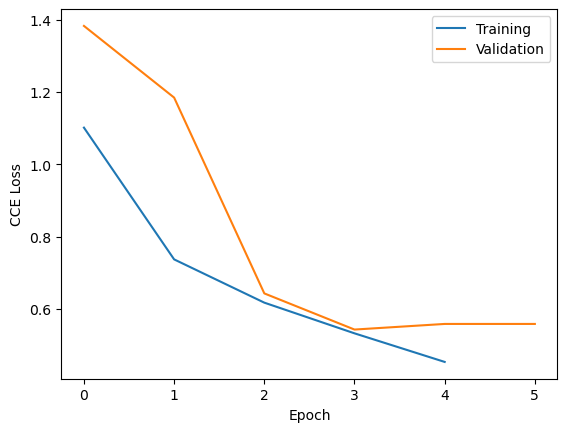

In [141]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")
plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()

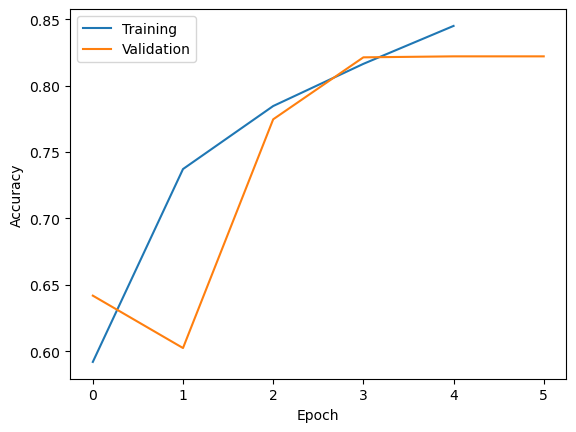

In [142]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))],
         results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))],
         results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))],
         label="Validation")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()